In [122]:
import sys
sys.path.append('../src')
import os

import warnings
warnings.simplefilter('ignore')

import pandas as pd
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)
import pandas_profiling as pdp

import dask
import dask.dataframe as dd
from dask.distributed import LocalCluster

import stumpy

import cufflinks
cufflinks.go_offline()
import plotly
from plotly import express as px
import matplotlib.pyplot as plt

from glob import glob
from time import ctime
import numpy as np

from tqdm.notebook import tqdm

from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import make_pipeline, make_union
from sklearn.cluster import KMeans

In [2]:
def split_trip_nan(trip, min_length=10):
    res = []
    nans = np.where(trip.isna())[0]
    for i in range(len(nans)-1):
        tmp = trip.iloc[nans[i]+1:nans[i+1]]
        if len(tmp) >= min_length:
            res.append(tmp)
    return res

# LOAD DATA

In [3]:
df = pd.read_parquet('../data/mod/data.parquet')

In [4]:
df = df.astype({
    'car_vin' :'str',
    'imei': 'str',
    'license_plate': 'str',
    'car_model': 'str',
    'lat':np.float16,
    'lon':np.float16,
    'alt':np.int32,
    'speed':np.uint8,
})

# RESAMPLEING

In [5]:
RESAMPLE_FREQ = '30s'
WINDOW_SIZE = 10

In [6]:
df = df[df.car_vin != 'None']
df['moving_speed'] = df['speed']
df.loc[df['speed'] == 0, 'moving_speed'] = np.nan
df_resampled = df.groupby('car_vin')['moving_speed'].resample(RESAMPLE_FREQ).mean()

In [7]:
%time tmp = df_resampled.groupby('car_vin').apply(split_trip_nan)

CPU times: user 2min 9s, sys: 21 ms, total: 2min 9s
Wall time: 2min 9s


## PREPARE WINDOW LIST

In [56]:
res = []
for car_vin in tmp.index:
    for ts in tmp.loc[car_vin]:
        ts = ts.tolist()
        for i in range(len(ts) - WINDOW_SIZE):
            res.append(ts[i:i + WINDOW_SIZE])

In [57]:
SUBSAMPLE_SIZE = 10_000

rand_ind = np.random.permutation(len(res))[:SUBSAMPLE_SIZE]
window_list = np.asarray(res)[rand_ind]
dist = np.corrcoef(window_list)
nearest_neighbor = np.argsort(dist)[:,-12:-2]

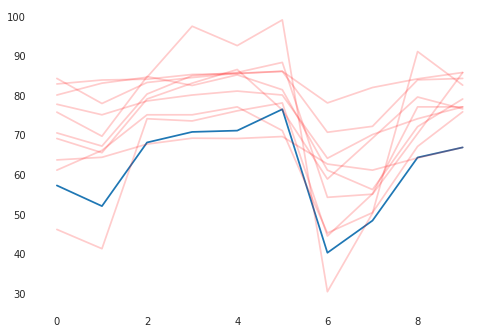

In [99]:
# PLOT RANDOM NEIGHBOURS

rand_chunk = np.random.choice(len(nearest_neighbor))

plt.plot(window_list[rand_chunk])
for i in nearest_neighbor[rand_chunk]:
    plt.plot(window_list[i], color='red', alpha=0.2)

# PROJECTION

In [155]:
N_CLUSTERS  = 3

cluster = make_pipeline(Normalizer(), KMeans(N_CLUSTERS)).fit_predict(window_list)
transformer = make_pipeline(Normalizer(), PCA(n_components=2))
proj = transformer.fit_transform(window_list)

In [156]:
proj = pd.DataFrame(proj, columns=['x','y'])
proj.reset_index(inplace=True)
proj['cluster'] = cluster

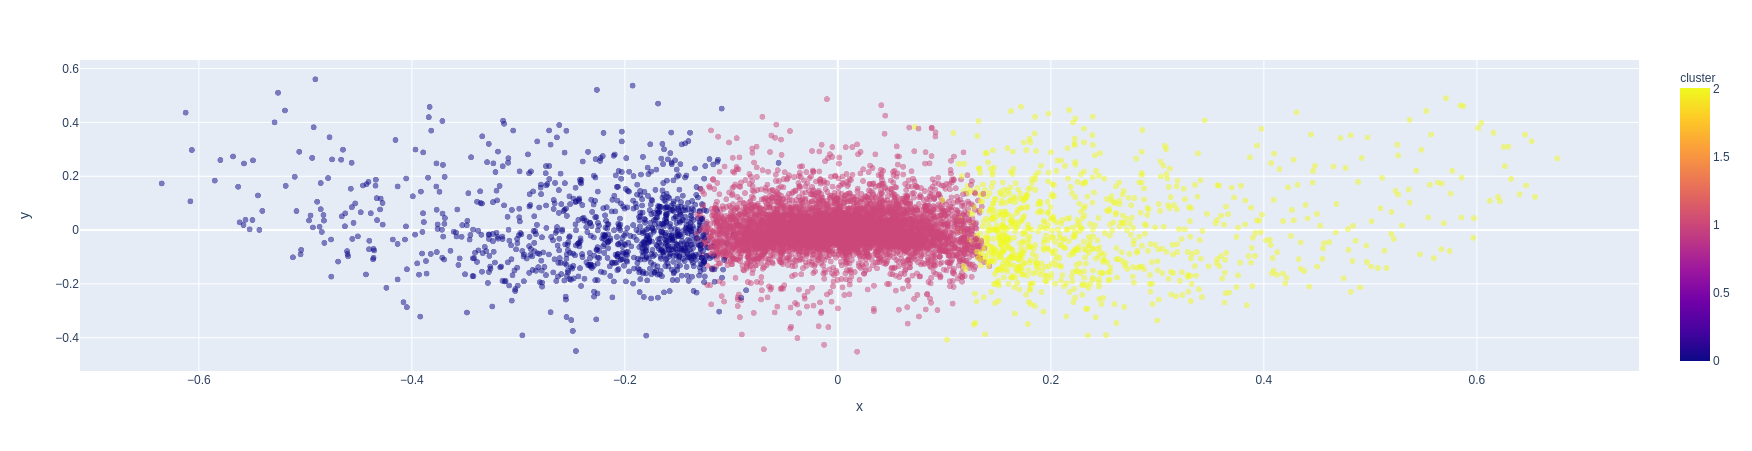

In [157]:
px.scatter(proj, x='x',y='y', hover_data=['index'], color='cluster', opacity=0.5)

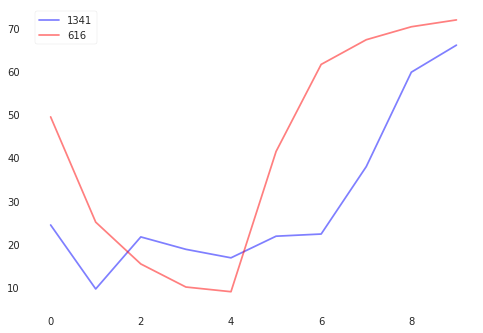

In [158]:
ID_1 = 1341
ID_2 = 616

plt.plot(window_list[ID_1], color='blue', alpha=0.5, label=ID_1)
plt.plot(window_list[ID_2], color='red', alpha=0.5, label=ID_2)
plt.legend()